<a href="https://colab.research.google.com/github/as9786/ParrotnlpJeju/blob/main/97_84(%EC%A0%84%EC%B2%98%EB%A6%AC%2BWord2Vec%2BCNN%2BGRU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사전작업

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
import gensim
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, GRU, Bidirectional, GlobalMaxPooling1D,GlobalAveragePooling1D, Dropout,SpatialDropout1D,Conv1D,concatenate,Flatten
#Bidirectional은 양방향으로 데이터를 보기 위해서 사용되는 함수
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
#데이터 불러오기
train_data = pd.read_csv('/content/drive/MyDrive/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/test.csv')

In [ ]:
train_data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [ ]:
train_data.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [ ]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    #text = re.sub(r'(@.*?)[\s]', ' ', text)
    #text = re.sub(r'&amp;', '&', text)
    text = text.strip(' ')
    return text

In [ ]:
X_train_raw = train_data['comment_text']#.map(lambda com : clean_text(com))
X_test_raw = test_data['comment_text']#.map(lambda com : clean_text(com))

bad_comment_cat = ['toxic', 'severe_toxic', 'obscene', 'threat',\
       'insult', 'identity_hate']
Y_train = train_data[bad_comment_cat]

In [ ]:
print("X train shape : ", X_train_raw.shape)
print("X test shape : ", X_test_raw.shape)
print("y train shape : ", Y_train.shape)

X train shape :  (159571,)
X test shape :  (153164,)
y train shape :  (159571, 6)


# 토큰화 작업하기

In [ ]:
max_features=20000
maxlen=200
embed_size=300


tok=Tokenizer(num_words=max_features,lower=True)
tok.fit_on_texts(X_train_raw)
tok.fit_on_texts(X_test_raw)
X_train = sequence.pad_sequences(tok.texts_to_sequences(X_train_raw),
                        maxlen = maxlen, truncating = "pre")
X_test = sequence.pad_sequences(tok.texts_to_sequences(X_test_raw),
                       maxlen = maxlen, truncating = "pre")

In [ ]:
word_index = tok.word_index

In [ ]:
word_index = {e:i for e,i in word_index.items() if i <= max_features}

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train,train_size=0.9, random_state=199)
print(x_train.shape," ",y_train.shape," ",x_val.shape," ",y_val.shape)

(143613, 200)   (143613, 6)   (15958, 200)   (15958, 6)


In [ ]:
!wget "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-04-06 12:23:13--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.97.174
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.97.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  5.45MB/s    in 72s     

2021-04-06 12:24:25 (21.9 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)  

In [ ]:
embedding_matrix = np.zeros((max_features, 300))

In [ ]:
def get_vector(word):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None

In [ ]:
for word, i in word_index.items(): # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다.
    temp = get_vector(word) # 단어(key) 해당되는 임베딩 벡터의 300개의 값(value)를 임시 변수에 저장
    if temp is not None: # 만약 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embedding_matrix[i-1] = temp # 해당 단어 위치의 행에 벡터의 값을 저장한다.

# 모델 구성하기

In [ ]:
input = Input(shape=(maxlen, )) 
layer = Embedding(max_features, 300, weights=[embedding_matrix], input_length=maxlen, trainable=True)(input)
layer = SpatialDropout1D(0.1)(layer)
layer = Bidirectional(GRU(128, return_sequences=True))(layer)
layer = Bidirectional(GRU(128, return_sequences=True))(layer)
layer = Conv1D(128, kernel_size = 3)(layer)   
#layer = Conv1D(64, kernel_size = 3)(layer)  
avg_pool = GlobalAveragePooling1D()(layer)
max_pool = GlobalMaxPooling1D()(layer)
layer = concatenate([avg_pool, max_pool])
#layer = Dense(32,activation='relu')(layer)
#layer = Flatten()(layer)
layer= Dense(6, activation="sigmoid")(layer)
model = Model(inputs = input, outputs = layer)  
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 300)     6000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 200, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 200, 256)     330240      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [ ]:
hist = model.fit(x_train, y_train, epochs=4,batch_size=256, validation_data=(x_val,y_val))

Epoch 1/4
561/561 [==============================] - 287s 447ms/step - loss: 0.0975 - accuracy: 0.8962 - val_loss: 0.0477 - val_accuracy: 0.9829
Epoch 2/4
561/561 [==============================] - 249s 443ms/step - loss: 0.0446 - accuracy: 0.9901 - val_loss: 0.0452 - val_accuracy: 0.9911
Epoch 3/4
561/561 [==============================] - 248s 441ms/step - loss: 0.0383 - accuracy: 0.9842 - val_loss: 0.0463 - val_accuracy: 0.9937
Epoch 4/4
561/561 [==============================] - 247s 440ms/step - loss: 0.0329 - accuracy: 0.9866 - val_loss: 0.0468 - val_accuracy: 0.9909


In [ ]:
model.save('/content/drive/MyDrive/toxic1_model0406-1.h5')

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('/content/drive/MyDrive/submission17.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt
def acc_loss_plot(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc = 'upper left')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')

    plt.show()

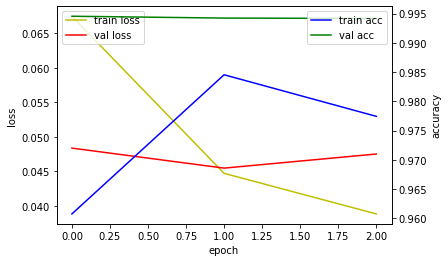

In [ ]:
acc_loss_plot(hist)